<a href="https://colab.research.google.com/github/Delaunay-I/image_cap_generator/blob/main/caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
keras version 2.12.0
tensorflow version 2.12.0


In [64]:
!pip install opendatasets
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


In [65]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./flickr8k/Images"
## The location of the caption file
dir_Flickr_text = "./flickr8k/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


Preliminary Analysis

In [66]:
df_txt = pd.read_csv(dir_Flickr_text, skiprows=1, names=["filename", "caption"])
df_txt['caption'] = df_txt['caption'].str.lower()

df_txt['index'] = df_txt.groupby("filename").cumcount()

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

# Looking at some image with their captions

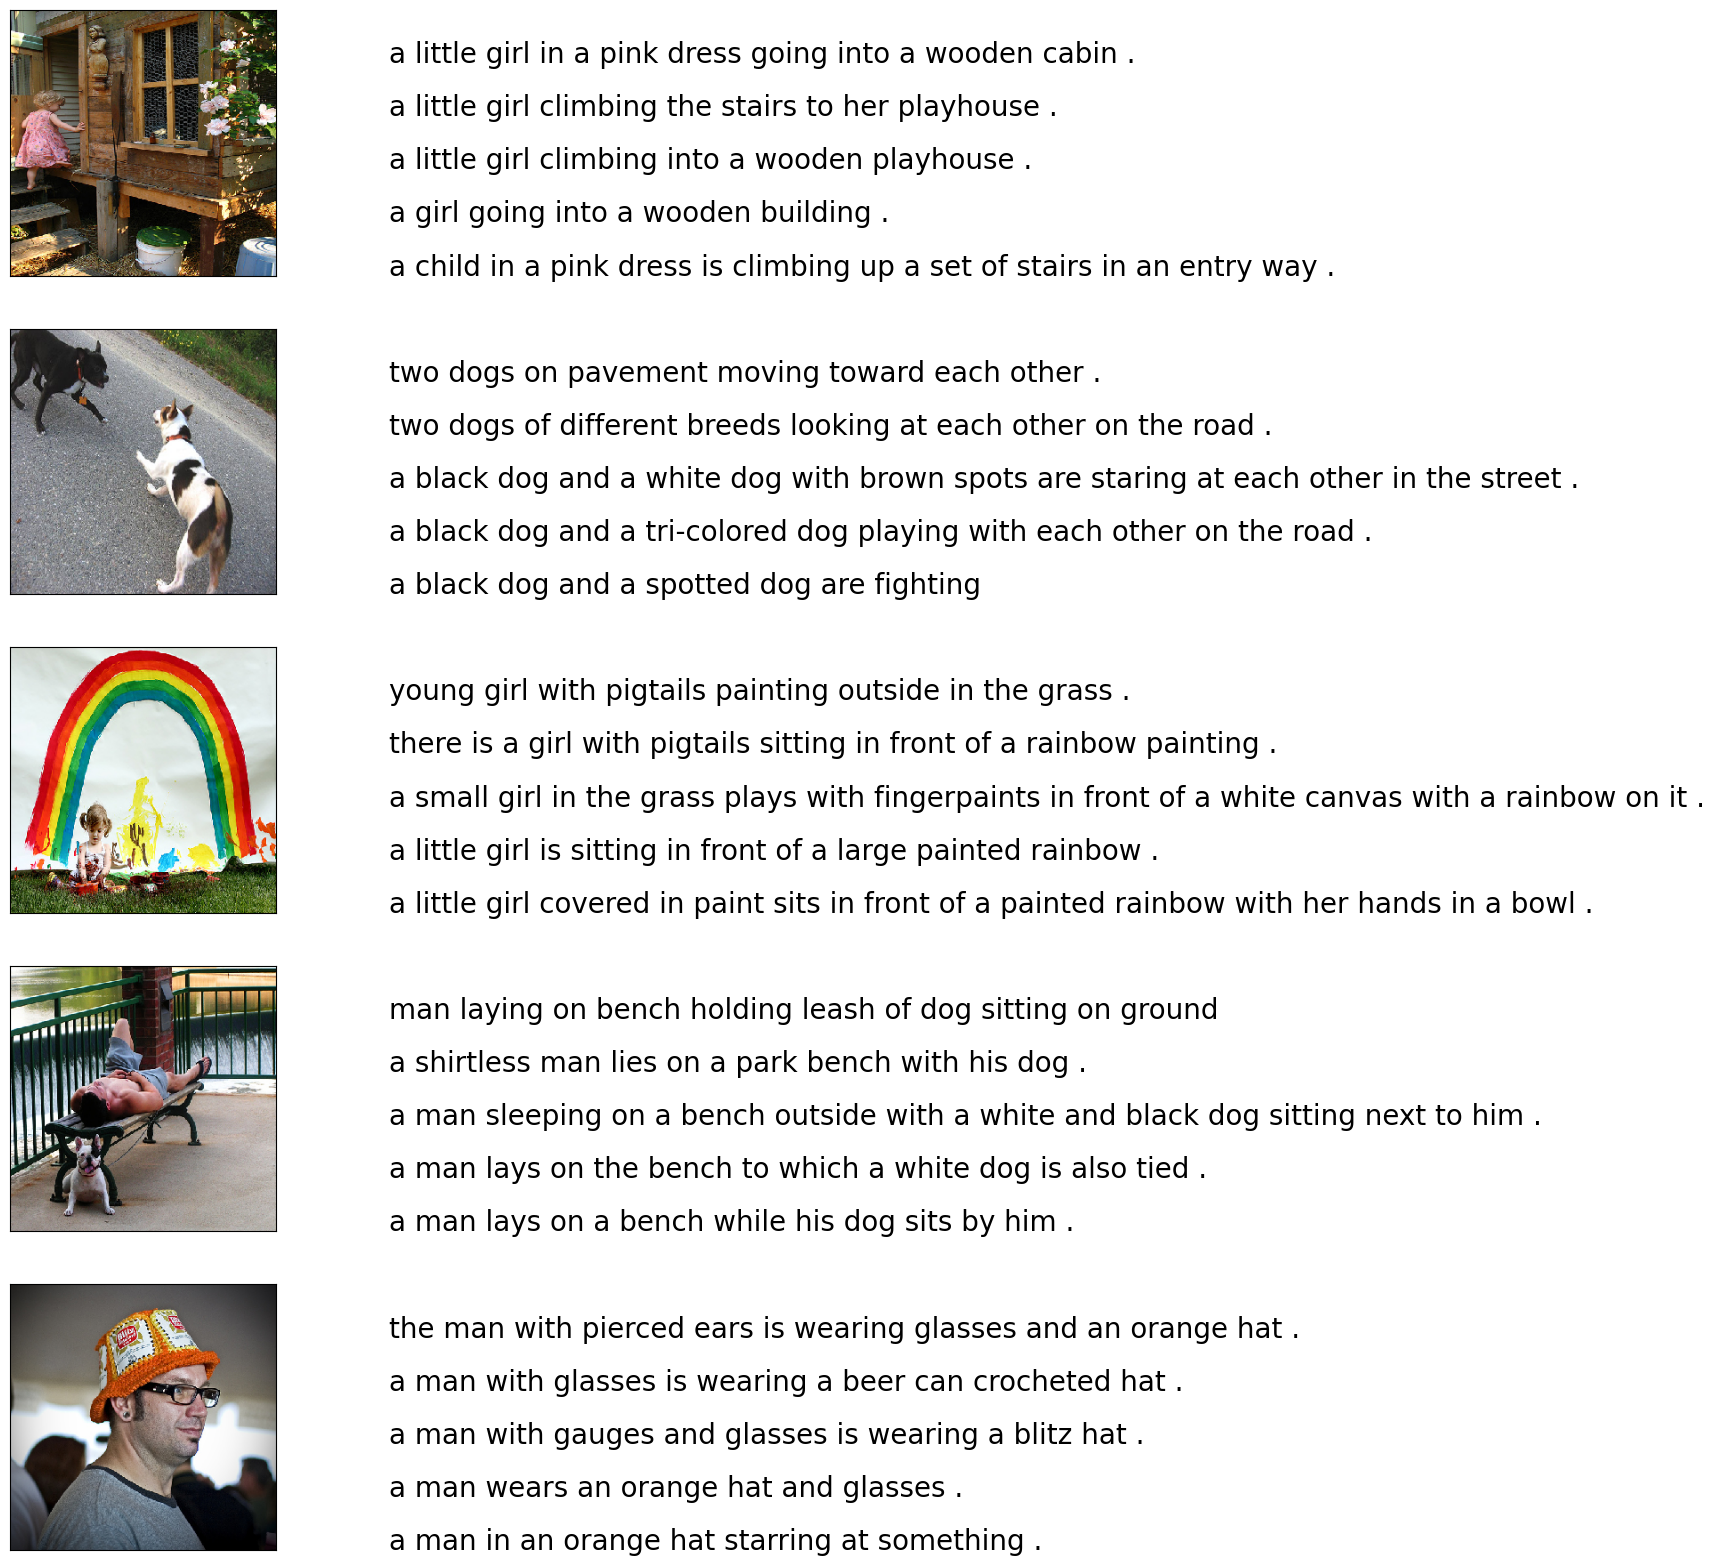

In [67]:
from tensorflow.keras.utils import load_img, img_to_array

npic = 5
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Data prepration
prepare text and image separately

In [68]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values(by="count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62986
1,.,36577
2,in,18974


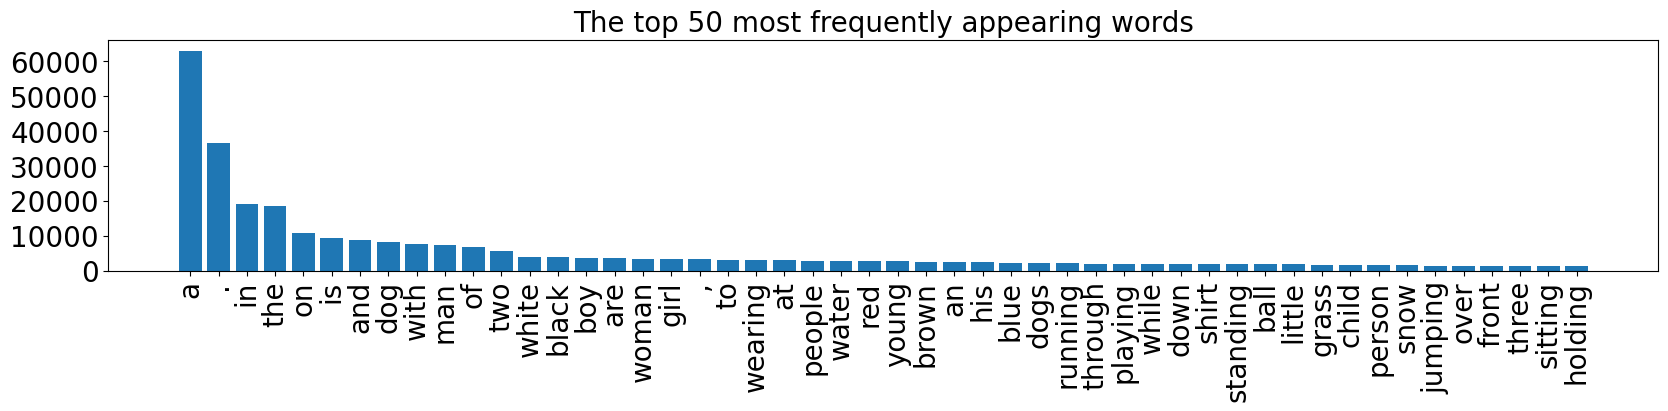

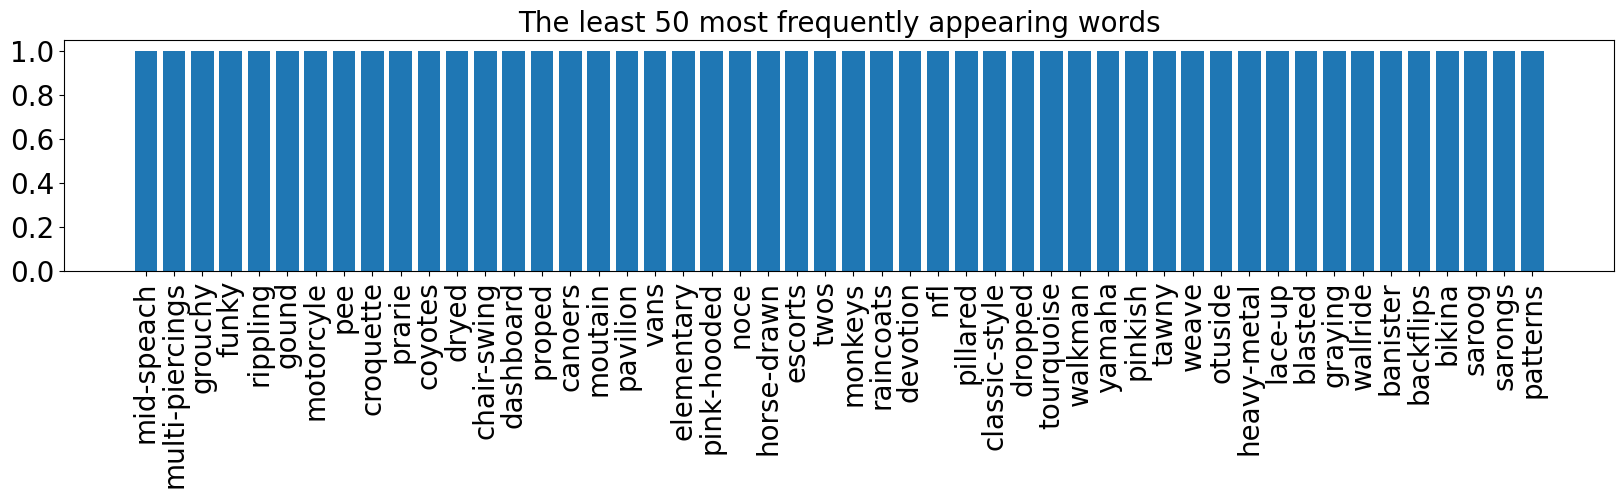

In [69]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Now we want to remove punctuation, single charachters, and remove numeric characters.

In [70]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [71]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

<ipython-input-71-0ca6825e3553>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_txt["caption"].iloc[i] = newcaption


Vocabulary Size: 8763


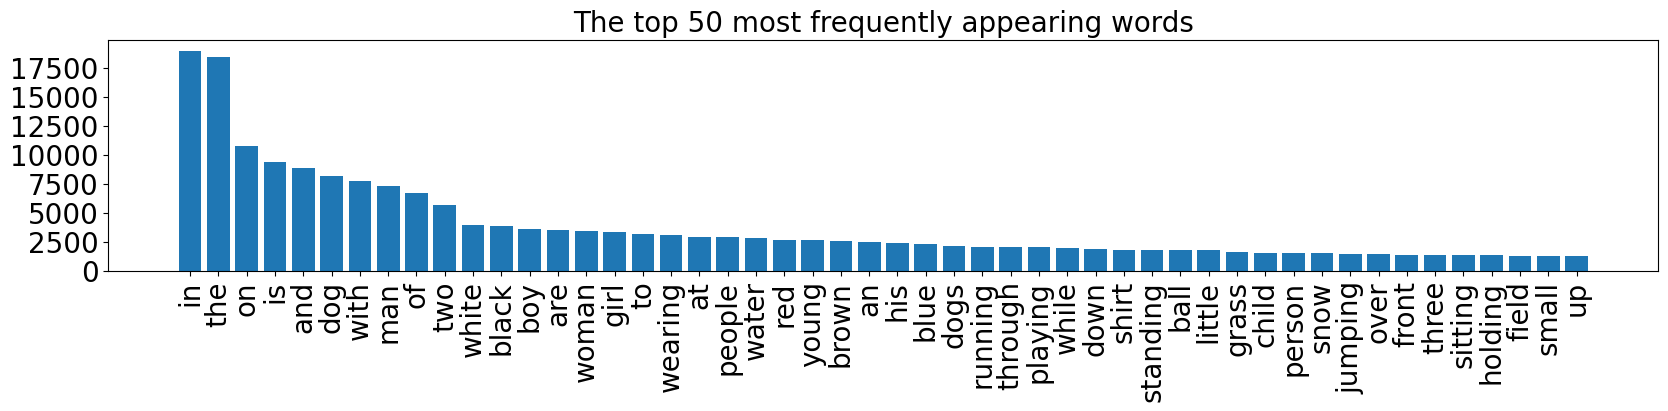

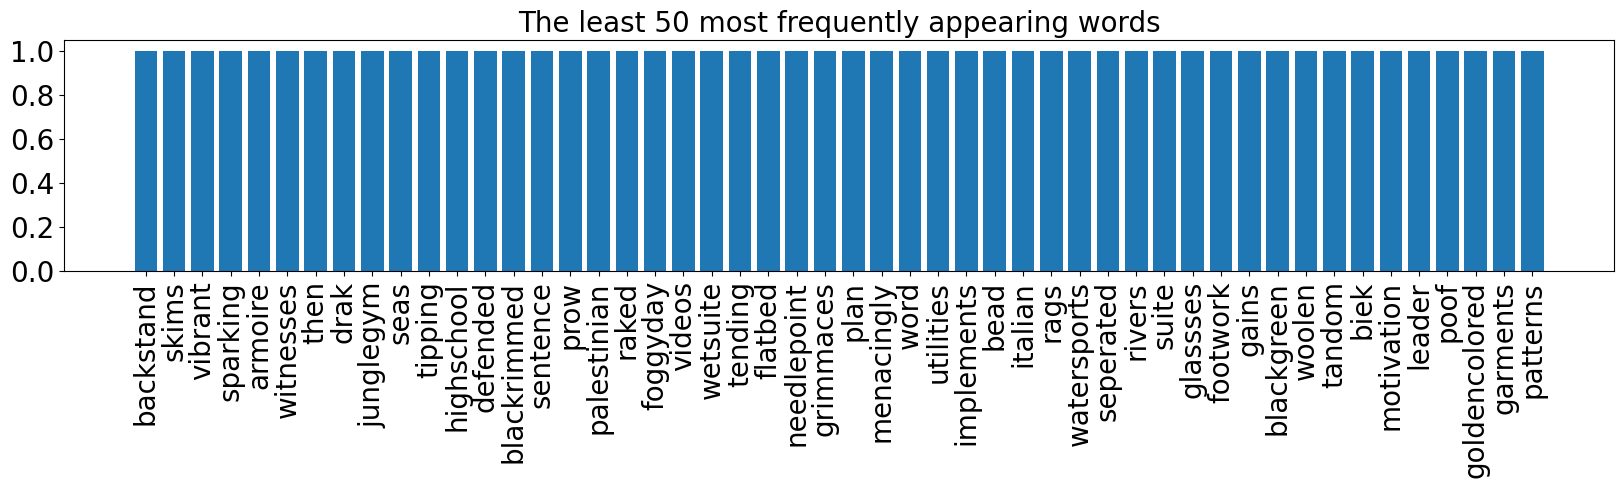

In [72]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

## Lemmatization Using NLTK library
Also removing the stop words

In [73]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download ('wordnet')
# nltk.download('punkt')
# # Download the averaged_perceptron_tagger resource.
# # Needed for the pos_tag() function
# nltk.download('averaged_perceptron_tagger')

# # Define a function to convert POS tags to WordNet format
# def get_wordnet_pos(tag):
#   if tag.startswith('J'):
#     return 'a' # adjective
#   elif tag.startswith('V'):
#     return 'v' # verb
#   elif tag.startswith('N'):
#     return 'n' # noun
#   elif tag.startswith('R'):
#     return 'r' # adverb
#   else:
#     return 'n' # default noun

# # Define a function to remove stop words and lemmatize a text
# def preprocess(text):
#   # Convert the text to lower case
#   text = text.lower()
#   # Tokenize the text
#   tokens = word_tokenize(text)
#   # Remove stop words
#   stop_words = stopwords.words('english')
#   tokens = [token for token in tokens if token not in stop_words]
#   # Lemmatize the tokens with their POS tags
#   lemmatizer = WordNetLemmatizer ()
#   tags = nltk.pos_tag(tokens)
#   tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tags]
#   # Return the preprocessed text as a string
#   return " ".join(tokens)

# # apply the function to the text column
# # df_txt['old_caption'] = df_txt['caption']
# df_txt['caption'] = df_txt['caption'].apply(preprocess)

# # print the dataframe
# df_txt.head(5)

Vocabulary Size: 8763


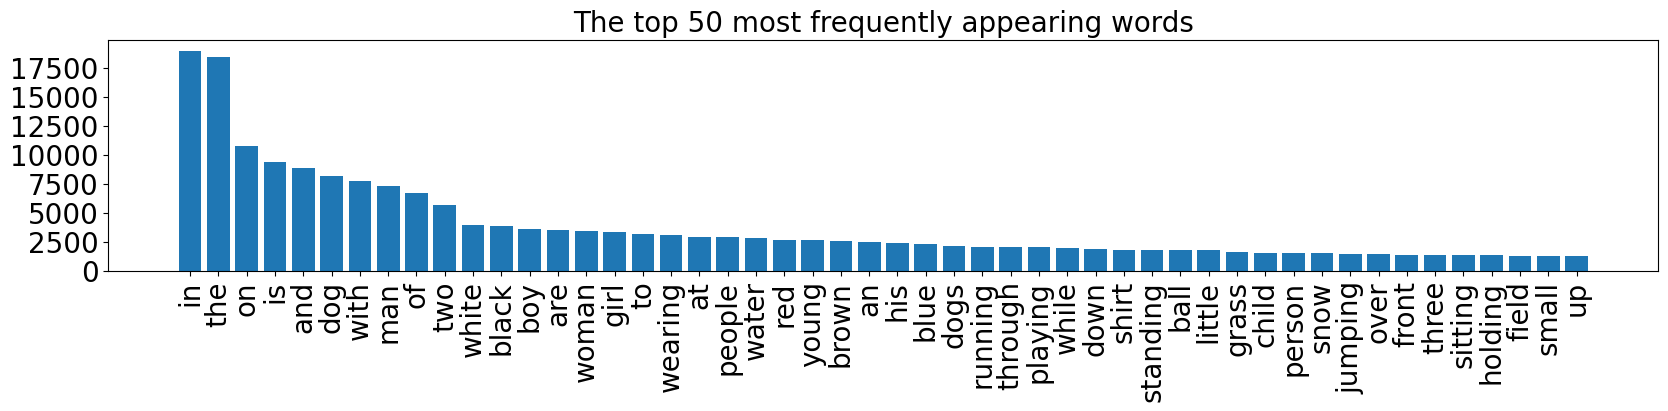

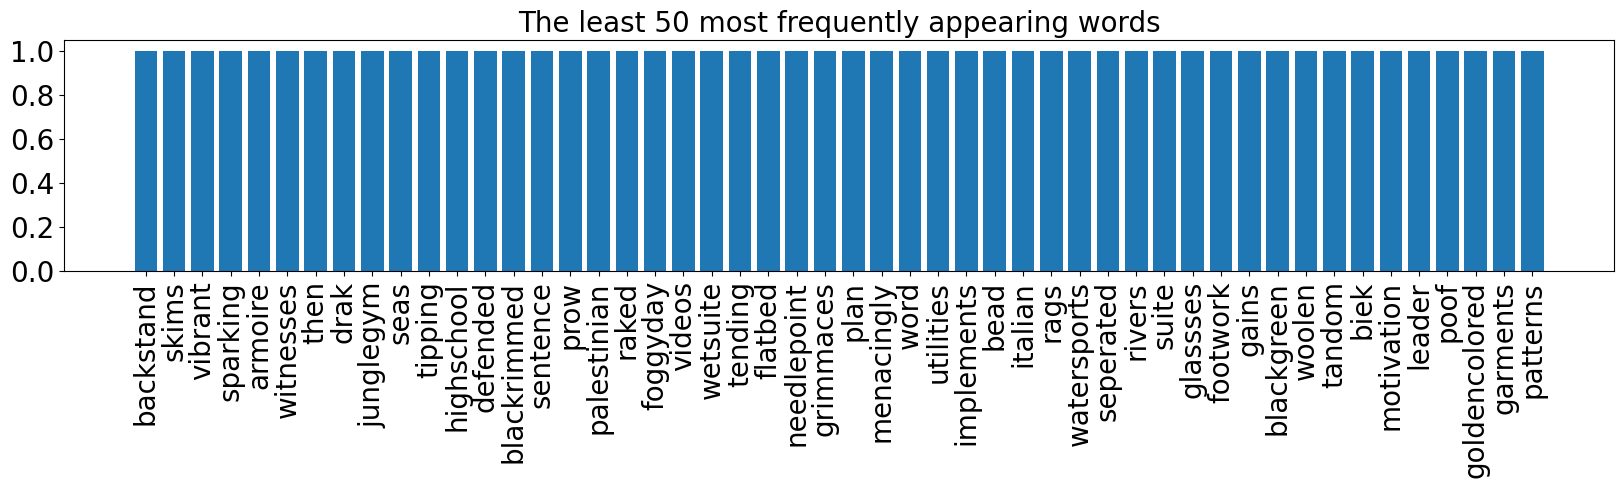

In [74]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [75]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [76]:
df_txt0

,filename,caption,index
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up s...,0
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq,1
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden pla...,2
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to h...,3
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into...,4
...,...,...,...
40450,997722733_0cb5439472.jpg,startseq man in pink shirt climbs rock face e...,0
40451,997722733_0cb5439472.jpg,startseq man is rock climbing high in the air...,1
40452,997722733_0cb5439472.jpg,startseq person in red shirt climbing up rock...,2
40453,997722733_0cb5439472.jpg,startseq rock climber in red shirt endseq,3


# Image prepration
## create features for image using InceptionV3 model

In [77]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(weights='imagenet')
image_model = Model(inputs = base_model.input, outputs=base_model.layers[-2].output)

In [78]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
import glob
import pickle

train_path = dir_Flickr_jpg
path_all_images = glob.glob(train_path + '/*jpg')

train_img = []  # list of all images in training set
for im in path_all_images:
  file_name = os.path.basename(os.path.normpath(im))
  if(file_name in df_txt0.filename.to_list()):
    train_img.append(im)

def preprocess(image_path):
  # inception v3 excepts img in 299 * 299 * 3
  image = load_img(image_path, target_size=(299, 299))
  # convert the image pixels to a numpy array
  x = img_to_array(image)
  # Add one more dimension
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  return x

def encode(image_path):
  image = preprocess(image_path)
  vec = image_model.predict(image, verbose=0)
  vec_flattened = vec.flatten()
  return vec_flattened


image_data = {}
if not os.path.exists('inceptionV3_image_encoder.pkl'):
    for image in train_img:
        file_name = os.path.basename(os.path.normpath(image))
        image_data[image] = encode(image)
    # Save the image features
    with open('inceptionV3_image_encoder.pkl', 'wb') as f:
      pickle.dump(image_data, f)

else:
    # Load previously encoded image data
    with open('inceptionV3_image_encoder.pkl', 'rb') as f:
        image_data = pickle.load(f)

    # # Check for new images and encode them
    # for image in train_img:
    #     if image not in image_data:
    #         file_name = os.path.basename(os.path.normpath(image))
    #         image_data[image] = encode(image)

    # # Save updated image data
    # with open('inceptionV3_image_encoder.pkl', 'wb') as f:
    #     pickle.dump(image_data, f)

# Tokenize the captions

In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer

captions_list = df_txt0.caption.to_list()

vocab_size = 8000
# Tokenizer does not limit the number of words
# it still finds all the words in the word_index
# But it will only use the num_words given to encode the text in texts_to_sequences or sequences_to_texts methods
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(captions_list)

# get the word index
word_index = tokenizer.word_index
train_seqs = tokenizer.texts_to_sequences(captions_list)

print(word_index)

# calculate the maximum caption length
max_length = max(len(seq) for seq in train_seqs)

{'<OOV>': 1, 'startseq': 2, 'endseq': 3, 'in': 4, 'the': 5, 'on': 6, 'is': 7, 'and': 8, 'dog': 9, 'with': 10, 'man': 11, 'of': 12, 'two': 13, 'white': 14, 'black': 15, 'boy': 16, 'are': 17, 'woman': 18, 'girl': 19, 'to': 20, 'wearing': 21, 'at': 22, 'people': 23, 'water': 24, 'red': 25, 'young': 26, 'brown': 27, 'an': 28, 'his': 29, 'blue': 30, 'dogs': 31, 'running': 32, 'through': 33, 'playing': 34, 'while': 35, 'down': 36, 'shirt': 37, 'standing': 38, 'ball': 39, 'little': 40, 'grass': 41, 'child': 42, 'person': 43, 'snow': 44, 'jumping': 45, 'over': 46, 'front': 47, 'three': 48, 'sitting': 49, 'holding': 50, 'field': 51, 'small': 52, 'up': 53, 'by': 54, 'large': 55, 'green': 56, 'group': 57, 'one': 58, 'yellow': 59, 'her': 60, 'walking': 61, 'children': 62, 'men': 63, 'into': 64, 'air': 65, 'beach': 66, 'near': 67, 'mouth': 68, 'jumps': 69, 'another': 70, 'for': 71, 'street': 72, 'runs': 73, 'its': 74, 'from': 75, 'riding': 76, 'stands': 77, 'as': 78, 'bike': 79, 'girls': 80, 'outsi

In [99]:
tokenizer

8765

In [80]:
## CRASHED FOR RAM
# from  tensorflow.keras.utils import pad_sequences
# from  tensorflow.keras.utils import to_categorical


# # create input sequences and output sequences
# X1, X2, y = list(), list(), list()
# for index, row in df_txt0.iterrows():
#     pic = image_data[row['filename']]
#     seq = tokenizer.texts_to_sequences([row['caption']])[0]
#     for i in range(1, len(seq)):
#         in_seq, out_seq = seq[:i], seq[i]
#         in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#         out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#         X1.append(pic)
#         X2.append(in_seq)
#         y.append(out_seq)

# X1 = np.array(X1)
# X2 = np.array(X2)
# y = np.array(y)

In [85]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(df, tokenizer, max_length, vocab_size, image_data, batch_size):
    num_batches = len(df) // batch_size
    while True:
        for i in range(num_batches):
            batch_df = df.iloc[i*batch_size:(i+1)*batch_size]
            X1, X2, y = [], [], []
            for index, row in batch_df.iterrows():
                pic = image_data[row['filename']]
                seq = tokenizer.texts_to_sequences([row['caption']])[0]
                for j in range(1, len(seq)):
                    in_seq, out_seq = seq[:j], seq[j]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(pic)
                    X2.append(in_seq)
                    y.append(out_seq)
            yield [np.array(X1), np.array(X2)], np.array(y)

batch_size = 64
train_generator = data_generator(df_txt0, tokenizer, max_length, vocab_size, image_data, batch_size)


# Downloading GloVe to using its vector embeddings

In [86]:
import urllib.request
import zipfile

# Set the URL for the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Set the path where the embeddings will be stored
embeddings_dir = 'embeddings/glove'

# Create the directory if it doesn't exist
if not os.path.exists(embeddings_dir):
    os.makedirs(embeddings_dir)

# Set the file name for the embeddings archive
embeddings_zip = os.path.join(embeddings_dir, 'glove.6B.zip')

# Download the embeddings archive if it doesn't exist
if not os.path.exists(embeddings_zip):
    print(f'Downloading GloVe embeddings from {url}...')
    urllib.request.urlretrieve(url, embeddings_zip)
    print('Done!')

# Extract the embeddings if they haven't been extracted yet
if not os.path.exists(os.path.join(embeddings_dir, 'glove.6B.100d.txt')):
    print('Extracting GloVe embeddings...')
    with zipfile.ZipFile(embeddings_zip, 'r') as zip_ref:
        zip_ref.extractall(embeddings_dir)
    print('Done!')


In [101]:
# load GloVe embeddings
embeddings_index = {}
glove_path = "./embeddings/glove/glove.6B.200d.txt"

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# filter out the words that are not in the top num_words-1 most frequent words
filtered_word_index = {word: i for word, i in tokenizer.word_index.items() if i < vocab_size}

# prepare embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in filtered_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model

In [102]:
from tensorflow.keras import layers, Model

# define the model
ip1 = layers.Input(shape = (2048, ))
fe1 = layers.Dropout(0.2)(ip1)
fe2 = layers.Dense(256, activation = 'relu')(fe1)
ip2 = layers.Input(shape = (max_length, ))
se1 = layers.Embedding(vocab_size, embedding_dim, mask_zero = True)(ip2)
se2 = layers.Dropout(0.2)(se1)
se3 = layers.LSTM(256)(se2)
decoder1 = layers.add([fe2, se3])
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
outputs = layers.Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)

# Train the model

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

num_batches = len(df_txt0) // batch_size
model.fit(train_generator, epochs = 50, steps_per_epoch=num_batches, verbose = 1)
# you can increase the number of epochs for better results

Epoch 1/50
632/632 [==============================] - 102s 153ms/step - loss: 4.6702
Epoch 2/50
632/632 [==============================] - 110s 173ms/step - loss: 3.7042
Epoch 3/50
632/632 [==============================] - 101s 160ms/step - loss: 3.3669
Epoch 4/50
632/632 [==============================] - 101s 160ms/step - loss: 3.1555
Epoch 5/50
632/632 [==============================] - 105s 166ms/step - loss: 2.9919
Epoch 6/50
632/632 [==============================] - 100s 159ms/step - loss: 2.8607
Epoch 7/50
632/632 [==============================] - 93s 146ms/step - loss: 2.7565
Epoch 8/50
632/632 [==============================] - 94s 149ms/step - loss: 2.6750
Epoch 9/50
632/632 [==============================] - 94s 149ms/step - loss: 2.6086
Epoch 10/50
632/632 [==============================] - 108s 170ms/step - loss: 2.5517
Epoch 11/50
632/632 [==============================] - 96s 152ms/step - loss: 2.5014
Epoch 12/50
632/632 [==============================] - 92s 145ms/st

## Saving the model

In [ ]:
# define some custom metadata for the model
metadata = {
  'name': 'image_caption_generator',
  'description': 'A model that generates captions for images using InceptionV3 and have all the stop words, and with no lemmatization',
  'parameters': {
    'vocab_size': 8000,
    'embedding_dim': 200,
    'lstm_units': 256,
    'beam_size': 5
  },
  'performance': {
    'loss': 2.34,
    'accuracy': 0.76,
    'bleu_score': 'NaN'
  }
}

# save the model with the metadata
model.save('img_cap_model_v2.h5', metadata=metadata)

In [ ]:
model = tf.keras.models.load_model('img_cap_model_v2.h5')

In [ ]:
from PIL import Image
import cv2

# Load and preprocess the new image
img = encode('./test_img.jpg')
img = img.reshape((1, 2048))

# Generate the caption
caption = [tokenizer.word_index["startseq"]]

for i in range(max_length):
    seq = pad_sequences([caption], maxlen=max_length)
    pred = model.predict([img, seq])
    pred_word_index = np.argmax(pred[0][i])
    if pred_word_index in tokenizer.index_word:
        pred_word = tokenizer.index_word[pred_word_index]
        caption.append(pred_word_index)
        if pred_word == 'endseq':
            break

# Convert the caption back to text
caption = tokenizer.sequences_to_texts([caption])[0]

print(caption)

In [ ]:
te = encode('./test_img.jpg')
print(te.shape)
te =np.expand_dims(te, axis=0)
print(te.shape)

In [ ]:
def predict_caption(image_path):
  # encode the image
  image_vec = encode(image_path)
  image_vec = image_vec.reshape(1, -1)
  # initialize the caption with the start token
  caption = [tokenizer.word_index['startseq']]
  # loop until the end token or the maximum length is reached
  for i in range(max_length):
    # pad the caption sequence
    padded_caption = pad_sequences([caption], maxlen=max_length, padding='post')
    # predict the next word using the model
    prediction = model.predict([image_vec, padded_caption], verbose=0)
    # get the word with the highest probability
    word_index = np.argmax(prediction)
    # append the word to the caption
    caption.append(word_index)
    # break if the end token is reached
    if word_index == tokenizer.word_index['endseq']:
      break
  # convert the caption indices to words
  caption_words = [tokenizer.index_word[i] for i in caption]
  # join the words to form a sentence
  caption_sentence = ' '.join(caption_words[1:-1])
  return caption_sentence

In [ ]:
generated_caption = predict_caption("./test_img.jpg")
print(generated_caption)

# Model 2, more complicated
* You can use a bidirectional LSTM instead of a single LSTM for the caption encoder. This way, you can capture the context from both directions of the caption sequence, and generate more coherent captions.

* You can use an attention mechanism to allow the decoder to focus on different parts of the image and the caption encoder outputs at each time step. This way, you can generate more relevant and informative captions that align with the image content.

* You can use a scheduled sampling technique to train the decoder with a mix of ground truth and predicted words. This way, you can reduce the exposure bias and improve the generalization ability of the decoder.

* You can use a beam search instead of a greedy search for generating captions. This way, you can explore more possible captions and choose the one with the highest probability.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Attention

# define the model
ip1 = layers.Input(shape = (2048, ))
fe1 = layers.Dropout(0.2)(ip1)
fe2 = layers.Dense(256, activation = 'relu')(fe1)
ip2 = layers.Input(shape = (max_length, ))
se1 = layers.Embedding(vocab_size, embedding_dim, mask_zero = True)(ip2)
se2 = layers.Dropout(0.2)(se1)
se3 = Bidirectional(layers.LSTM(256, return_sequences=True))(se2) # use bidirectional LSTM
decoder1 = layers.add([fe2, se3[:, -1]]) # use last hidden state of bidirectional LSTM
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
attn_layer = Attention() # use attention layer
context_vector, attention_weights = attn_layer([decoder2, se3]) # get context vector and attention weights
decoder3 = layers.Dense(256, activation='relu')(context_vector) # use context vector for final dense layer
outputs = layers.Dense(vocab_size, activation = 'softmax')(decoder3)
model_v2 = Model(inputs = [ip1, ip2], outputs = outputs)

model_v2.layers[3].set_weights([embedding_matrix])
model_v2.layers[3].trainable = False
model_v2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

num_batches = len(df_txt0) // batch_size
model_v2.fit(train_generator, epochs = 50, steps_per_epoch=num_batches, verbose = 1)

## Beam search

In [ ]:
def beam_search(image_path, beam_size):
  # encode the image
  image_vec = encode(image_path)
  # add another dimension to match the model input
  image_vec = np.expand_dims(image_vec, axis=0)
  # initialize the candidates with the start token
  candidates = [[tokenizer.word_index['<start>']]]
  # initialize the probabilities with 1
  probabilities = [1]
  # loop until the maximum length is reached
  for i in range(max_length):
    # initialize a list to store the next candidates
    next_candidates = []
    # initialize a list to store the next probabilities
    next_probabilities = []
    # loop over the current candidates
    for j in range(len(candidates)):
      # get the current candidate
      candidate = candidates[j]
      # pad the candidate sequence
      padded_candidate = pad_sequences([candidate], maxlen=max_length, padding='post')
      # predict the next word using the model
      prediction = model.predict([image_vec, padded_candidate], verbose=0)
      # get the top beam_size words and their probabilities
      top_words = np.argsort(prediction[0])[-beam_size:]
      top_probs = prediction[0][top_words]
      # loop over the top words and their probabilities
      for k in range(beam_size):
        # get the word and its probability
        word = top_words[k]
        prob = top_probs[k]
        # append the word to the candidate and multiply the probability
        next_candidate = candidate + [word]
        next_prob = probabilities[j] * prob
        # append the next candidate and probability to the lists
        next_candidates.append(next_candidate)
        next_probabilities.append(next_prob)
    # sort the next candidates and probabilities by descending order of probability
    sorted_indices = np.argsort(next_probabilities)[::-1]
    sorted_candidates = [next_candidates[i] for i in sorted_indices]
    sorted_probabilities = [next_probabilities[i] for i in sorted_indices]
    # select the top beam_size candidates and probabilities for the next iteration
    candidates = sorted_candidates[:beam_size]
    probabilities = sorted_probabilities[:beam_size]
    # check if any candidate has reached the end token
    end_index = tokenizer.word_index['<end>']
    if any(candidate[-1] == end_index for candidate in candidates):
      break
  # return the candidate with the highest probability
  best_candidate = candidates[0]
  # convert the candidate indices to words
  caption_words = [tokenizer.index_word[i] for i in best_candidate]
  # join the words to form a sentence
  caption_sentence = ' '.join(caption_words[1:-1])
  return caption_sentence